In [1]:
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from itertools import islice
from collections import defaultdict, Counter
from Bio import Entrez, SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.Data import CodonTable
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceMatrix
from sklearn import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import (
    ttest_ind,
    t,
    norm,
    gaussian_kde,
    pearsonr,
    f_oneway
)
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d
import localcider
from localcider.sequenceParameters import SequenceParameters
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from math import log2

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import copy


In [2]:
class ORF_features:
    """
    When instantiated, calculates various sequence features for an amino acid sequence
    """
    def __init__(self, sequence, origin):
        self.sequence = str(sequence)  # in amino acids
        self.origin = origin
        processed_seq = self.sequence.replace('*', '') # LocalCIDER doesn't handle *

        #molecular features
        seq = SequenceParameters(processed_seq)

        # For info on molecular features, see:
        # LOCALCIDER @ http://pappulab.github.io/localCIDER/
        # CIDER: Classification of Intrinsically Disordered Ensemble Regions
        
        self.FCR = seq.get_FCR(pH=None)
        self.net_charge = seq.get_mean_net_charge()
        self.frac_negative = seq.get_fraction_negative()
        self.frac_positive = seq.get_fraction_positive()
        self.kappa = seq.get_kappa()
        self.omega = seq.get_Omega()
        self.frac_disorder_promoting = seq.get_fraction_disorder_promoting()
        self.PI = seq.get_isoelectric_point()
        self.hydropathy = seq.get_uversky_hydropathy()
        self.PPII = seq.get_PPII_propensity(mode='hilser') # Type II polyproline helices (PPII)
        self.delta = seq.get_delta() 
        self.entropy = self.entropy(self.sequence)
        
    def entropy(self, data):
        total = len(data)
        freqs = Counter(data)
        return -sum((count / total) * log2(count / total) for count in freqs.values())


class ORF_sequence:
    """
    When instantiated, calculates amino acid usage for a sequence
    """
    def __init__(self, sequence, origin):
        self.sequence = str(sequence)  # in amino acids
        self.origin = origin
        
        AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY*'
        for aa in AMINO_ACIDS:
            setattr(self, aa, (self.sequence.count(aa)/len(self.sequence)))


In [3]:
def normalize(protein_dict):
    """
    Returns a new dictionary where numeric values are Z-score normalized
    """
    exclude_keys = {'sequence', 'origin'} # These are not pertinent here
    normalized_dict = {}

    first_item = next(iter(protein_dict.values()))
    numeric_keys = [
        key for key in first_item
        if isinstance(first_item[key], (int, float)) and key not in exclude_keys
    ]

    # Collect data for each key across all sequences
    property_values = {key: [] for key in numeric_keys}
    for protein_data in protein_dict.values():
        for key in numeric_keys:
            property_values[key].append(protein_data[key])

    # Normalized values for each key
    normalized_values = {}
    for key in numeric_keys:
        values = np.array(property_values[key], dtype=float)
        mean_val = np.mean(values)
        std_val = np.std(values)

        if std_val == 0:
            normalized_values[key] = np.zeros_like(values)
        else:
            normalized_values[key] = (values - mean_val) / std_val

    for i, (protein_key, protein_data) in enumerate(protein_dict.items()):
        normalized_entry = {}
        for key, value in protein_data.items():
            if key in numeric_keys:
                normalized_entry[key] = normalized_values[key][i]
            else:
                normalized_entry[key] = copy.deepcopy(value)
        normalized_dict[protein_key] = normalized_entry

    return normalized_dict

def plot_PCA(protein_info, margin,  xmin, xmax, ymin, ymax, screeplot = False, loadings = False, scale = 20):

    """
    This plots generated and true sequences in the same reduced space
    It generates a density distribution using a Kernel density estimation for generated sequences
    Then layers the true sequences points on this distribution
    It then ranks generated points along the density distribution and estimates likeliness of true points.
    """
    
    targets = []
    features = []

    normalized_protein_info = normalize(protein_info)

    exclude_keys = ['reading_frame', 'origin', 'sequence']
    feature_keys = [
        key for key in next(iter(normalized_protein_info.values())).keys()
        if isinstance(normalized_protein_info[next(iter(normalized_protein_info))][key], (int, float))
        and key not in exclude_keys
    ]

    for entry in normalized_protein_info.values():
        targets.append(entry['origin'])
        feature_values = [entry[key] for key in feature_keys]
        features.append(feature_values)

    targets = np.array(targets)
    features = np.array(features)

    # Perform PCA
    pca = PCA()
    pca_results = pca.fit_transform(features)
    explained_variance = pca.explained_variance_ratio_ * 100 

    if screeplot == True:
        # Scree plot
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Explained (%)')
        plt.title('Scree Plot')
        plt.grid(alpha=0.3)
        plt.show()
    
    # Select first two components for plotting
    pc1_var = explained_variance[0]
    pc2_var = explained_variance[1]
    
    data_target_1 = pca_results[targets == 1, :2]
    #print(pca_results[targets == 1, :2])
    #data_target_0 = pca_results[targets == 0, :2]
    data_target_2 = pca_results[targets == 2, :2]
    
    x1_target_1, y2_target_1 = data_target_1[:, 0], data_target_1[:, 1]
    #x1_target_0, y2_target_0 = data_target_0[:, 0], data_target_0[:, 1]
    x1_target_2, y2_target_2 = data_target_2[:, 0], data_target_2[:, 1]
    
    # KDE estimation for target == 1 (generated degenerate sequences)
    data_target_1_kde = np.vstack([x1_target_1, y2_target_1])
    
    #kde_target_1 is the smooth estimate of KDE
    kde_target_1 = gaussian_kde(data_target_1_kde)
    
    # Grid setup for KDE
    x_min, x_max = x1_target_1.min(), x1_target_1.max()
    y_min, y_max = y2_target_1.min(), y2_target_1.max()
    x_range, y_range = x_max - x_min, y_max - y_min
    
    x, y = np.mgrid[
        x_min - margin * x_range : x_max + margin * x_range : 100j,
        y_min - margin * y_range : y_max + margin * y_range : 100j
    ]
    positions = np.vstack([x.ravel(), y.ravel()])
    density = kde_target_1(positions).reshape(x.shape)

    #interpolates a density curve 
    rankings = rankings_curve(data_target_1_kde, kde_target_1)

    #generate positions for target == 2 (real primate orthologs) and evaluate their density
    data_target_2_kde = np.vstack([x1_target_2, y2_target_2])
    density_real_proteins = kde_target_1(data_target_2_kde)

    # Assign rankings based on density for each primate orthologs)
    real_proteins_rank = rankings(density_real_proteins) 
    
    # Normalize log density from 0 to 1, better definition near 0 because of log
    density_log = np.log1p(density)
    density_log_normalized = (density_log - np.min(density_log)) / (np.max(density_log) - np.min(density_log))

    plt.figure(figsize=(10, 8))
    
    contour = plt.contourf(x, y, density_log_normalized, levels=100, cmap="gist_heat_r", alpha=0.7)
    cbar = plt.colorbar(contour)
    cbar.set_label('Normalized Log Density', fontsize = 14)
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.ax.tick_params(labelsize=13)
    contour_lines = plt.contour(x, y, density_log_normalized, levels=100, colors='purple', linewidths=0.1, alpha=0.5)

    colors = [assign_significance(rank)[1] for rank in real_proteins_rank]
    plt.scatter(x1_target_2, y2_target_2, color=colors, edgecolor='black', label='MTALTCO1')
    
    for i, rank in enumerate(real_proteins_rank):
        sign,colour = assign_significance(rank)
        plt.text(x1_target_2[i]+0.1, y2_target_2[i]+0.1, str(i), fontsize=13, color='black', ha='left', va='bottom')

    if loadings == True:
        for i, feature in enumerate(feature_keys):
            x_end, y_end = pca.components_[0, i], pca.components_[1, i]
    
            scale_factor = scale
            
            plt.arrow(0, 0, scale_factor*x_end, scale_factor*y_end,
                      color='red', alpha=0.5, head_width=0.5, length_includes_head=True)
            
            # feature label at the arrow tip
            plt.text(x_end * 1.05*scale_factor,  
                     y_end * 1.05*scale_factor,
                     feature,
                     fontsize=15,
                     ha='center', va='center') 

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='> 99.9%',  markerfacecolor='red', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='> 99.0%',  markerfacecolor='orange', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='> 95%',    markerfacecolor='yellow', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Expected', markerfacecolor='green', markersize=10, markeredgecolor='black')
    ]

        
    plt.xlabel(f"PC1 ({pc1_var:.2f}% variance explained)")
    plt.ylabel(f"PC2 ({pc2_var:.2f}% variance explained)")
    plt.xlim(xmin, xmax)  # Set x-axis limits
    plt.ylim(ymin, ymax)  # Set y-axis limits

    plt.title("Amino Acid Composition")
    plt.legend(handles=legend_elements, title="Unlikeliness", loc='upper right', fontsize=9, title_fontsize=11, frameon=True)

    plt.show()

def assign_significance(ranking):

    """
    Assigns an 'unlikeliness' based on KDE density estimate based ranking 
    """
    
    colours = ['green','yellow','orange','red']
    if ranking <= 0.001:
        return '***',colours[3]
    elif ranking <= 0.01:
        return '**',colours[2]
    elif ranking <= 0.05:
        return '*',colours[1]
    else:
        return '' ,colours[0]

def rankings_curve(all_proteins_PC_coordinates, kde_curve, plot = False):

    """
    Ranks sequences by density in KDE space
    outputs a function, that takes as input a KDE-density and outputs a rank
    """
    
    # Compute KDE densities at given coordinates
    density = kde_curve(all_proteins_PC_coordinates)
    
    # Sort densities in ascending order
    sorted_density = np.sort(density)
    
    # Normalized cumulative rank values from 0 to 1
    cumulative_ranks = np.linspace(0, 1, len(sorted_density))
    
    # Create interpolation function: KDE value -> cumulative rank
    kde_density_to_rank = interp1d(
        sorted_density,
        cumulative_ranks,
        bounds_error=False,
        fill_value=(0, 1),
        assume_sorted=True
    )
    
    # Generate interpolated cumulative ranks for plotting
    interpolated_cumulative = kde_density_to_rank(sorted_density)

    if plot == True:
        # Plot both curves for comparison
        plt.figure(figsize=(8, 5))
        
        # Original curve: rank vs KDE density
        plt.plot(cumulative_ranks, sorted_density , color='blue', label='Original Curve (Rank vs KDE)')
        
        # Interpolated curve: KDE density vs interpolated cumulative rank
        plt.plot(interpolated_cumulative, sorted_density, linestyle='--', color='orange', label='Interpolation Curve (KDE vs Rank)')
        
        plt.xlabel("Normalized protein index (rank) / KDE value")
        plt.ylabel("KDE value / Cumulative Proportion")
        plt.title("Comparison of KDE ranking and interpolation curves")
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return kde_density_to_rank




# Import primate degenerate and true sequences

In [4]:
msa_file = "/Users/francisrobitaille/Documents/FASTA_MOP/primate_DSS.fasta"
alignment = AlignIO.read(msa_file, 'fasta')


In [5]:
#check proper size
alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (567 records of length 258) at 14048c410>

# Compile sequence data

In [6]:
# Molecular features
protein_info_features = {}

for record in alignment:
    if 'true' in record.id:
        prot = ORF_features(str(record.seq), 2)
        protein_info_features[record.id] = {
            attr: getattr(prot, attr)
            for attr in dir(prot)
            if not attr.startswith("__") and not callable(getattr(prot, attr))
        } 

    if 'generated' in record.id:
        prot = ORF_features(str(record.seq), 1)
        protein_info_features[record.id] = {
            attr: getattr(prot, attr)
            for attr in dir(prot)
            if not attr.startswith("__") and not callable(getattr(prot, attr))
        }

# Amino acid usage
protein_info_sequence = {}

for record in alignment:
    if 'true' in record.id:
        prot = ORF_sequence(str(record.seq), 2)
        protein_info_sequence[record.id] = {
            attr: getattr(prot, attr)
            for attr in dir(prot)
            if not attr.startswith("__") and not callable(getattr(prot, attr))
        }

    if 'generated' in record.id:
        prot = ORF_sequence(str(record.seq), 1)
        protein_info_sequence[record.id] = {
            attr: getattr(prot, attr)
            for attr in dir(prot)
            if not attr.startswith("__") and not callable(getattr(prot, attr))
        }

# Compare MTALTCO1 to DSS individually for molecular features and amino acid usage

In [ ]:
#Refer to local.cider @ http://pappulab.github.io/localCIDER/ for additional information on features

features = [
    'FCR',                      
    'net_charge',               
    'frac_negative',            
    'frac_positive',            
    'kappa',                    
    'omega',                    
    'frac_disorder_promoting', 
    'PI',                       
    'hydropathy',               
    'PPII',                     
    'delta',                    
    'entropy'                   
]

def plot_one_feature(feature, protein_info):
    attribute = [(value[feature]) for value in protein_info.values()]

    # Store the last value separately
    MTALTCO1_is_first = attribute[0]
    
    plt.figure(figsize=(8, 5))
    plt.hist(attribute[1:], bins=10, color='skyblue', edgecolor='black', label = 'Expected')
    plt.axvline(MTALTCO1_is_first, color='red', linestyle='--', linewidth=2, label= 'MTALTCO1')
    plt.xlabel('% of sequence')
    plt.ylabel('Frequency')
    plt.title(f'{feature} content')
    plt.legend()
    plt.tight_layout()
    plt.show()

for ftr in features:
    plot_one_feature(ftr, protein_info_features)

In [ ]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWY*'

def plot_one_AA(amino_acid, protein_info):
    feature = [(value[amino_acid]*100) for value in protein_info.values()]
    
    MTALTCO1_is_first = feature[0]
    
    plt.figure(figsize=(8, 5))
    plt.hist(feature[1:], bins=10, color='skyblue', edgecolor='black', label = 'Expected')
    plt.axvline(MTALTCO1_is_first, color='red', linestyle='--', linewidth=2, label= 'MTALTCO1')
    plt.xlabel('% of sequence')
    plt.ylabel('Frequency')
    plt.title(f'Amino acid "{amino_acid}" content')
    plt.legend()
    plt.tight_layout()
    plt.show()

for AA in amino_acids:
    plot_one_AA(AA, protein_info_sequence)

# Plot PCA for features and amino acid usage

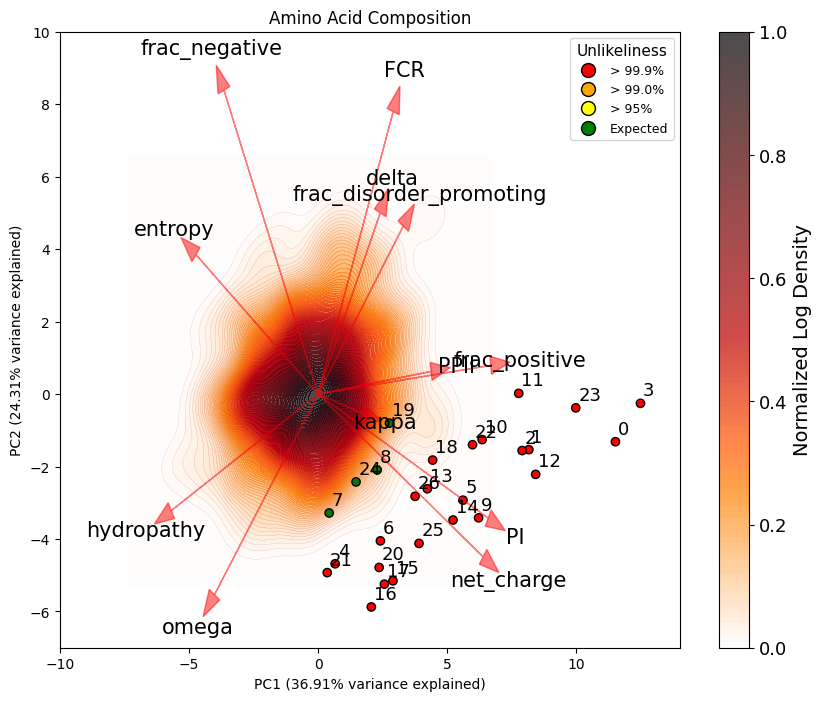

In [7]:
plot_PCA(protein_info_features, 0.2, -10, 14, -7, 10,loadings = True,scale = 18)


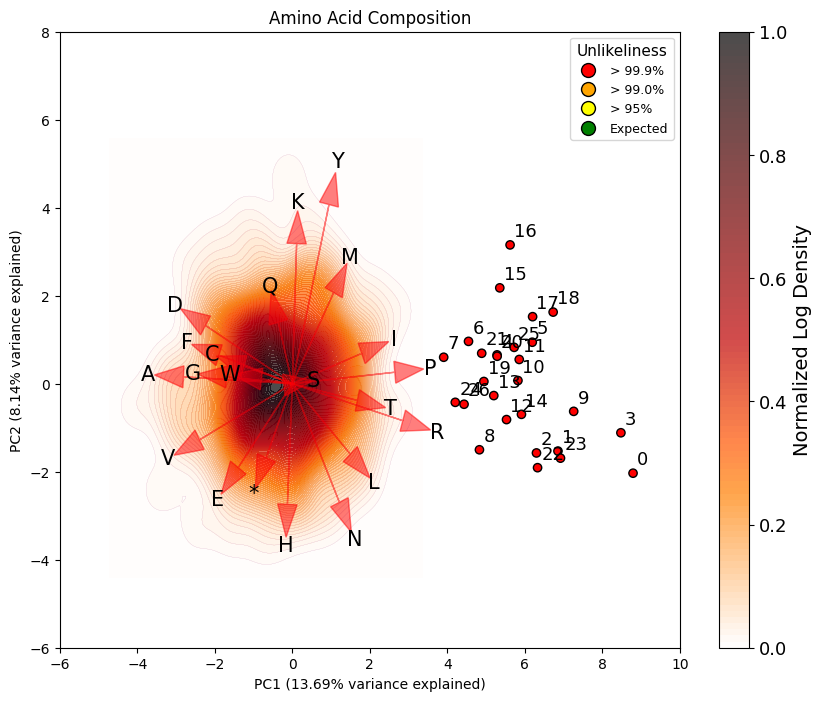

In [8]:
plot_PCA(protein_info_sequence, 0.1, -6, 10, -6, 8, loadings = True, scale = 10)
